# Tutorial for spatial mapping using _Tangram2-mapping_

- Adapted from the original [Tangram tutorial](https://github.com/broadinstitute/Tangram/blob/master/tutorial_tangram_with_squidpy.ipynb)  
- by Ziqing Lu <luz21@gene.com>, Hejin Huang <huang.hejin@gene.com>, and Tommaso Biancalani <biancalt@gene.com>  
- Last update: December 6th 2025  

_Tangram2_ has three modules:

- **Tangram2-mapping** – single-cell → spatial alignment (this notebook)  
- **Tangram2-CCC** – cell–cell communication analysis on top of the mapping  
- **Tangram2-evalkit** – tools to benchmark and compare mappings  

This notebook focuses **only** on _Tangram2-mapping_.

---

### What is _Tangram2-mapping_?

_Tangram2-mapping_ aligns single-cell (or single-nucleus) RNA-seq data to spatial transcriptomics data from the **same tissue or anatomical region**.  

Given:

- a single-cell dataset (with rich annotations such as cell types, subclasses or programs), and  
- a spatial dataset (Visium, Slide-seq, etc.) measured on the same tissue type,

_Tangram2-mapping_ learns how to place each cell in space by fitting gene expression on a shared set of genes. Once the mapping is learned, we can **project any annotation from the scRNA-seq (e.g. cell types, gene programs)** back onto the spatial coordinates.

Compared to the original Tangram implementation, _Tangram2-mapping_ uses an **improved loss function**, which generally leads to **more accurate and more stable mappings**, while keeping a very similar API.

---

### What can I use _Tangram2-mapping_ for?

Typical use cases include:

- **Cell-type localization**  
  Map scRNA-seq cell types (or clusters) onto spatial spots or pixels to see **where** each cell type lives in the tissue.

- **Denoising and imputing spatial gene expression**  
  Spatial technologies (e.g. Visium, Slide-seq) are often much sparser than scRNA-seq.  
  _Tangram2-mapping_ uses the richer single-cell data to generate a “new” spatial expression matrix with many more genes robustly recovered.

- **Visualizing gene programs in space**  
  If you have gene programs, metagenes, or other latent factors in your scRNA-seq data, you can project their usage to space and ask **where programs are active**.

***
## Setting up

_Tangram2-mapping_ is implemented in Python and builds on:

- **PyTorch** – optimization and neural network backend  
- **Scanpy** – handling of `AnnData` objects and standard single-cell preprocessing  
- **Squidpy** – convenient access to example spatial datasets and image utilities (optional, but strongly recommended)

This notebook is designed to work smoothly with **Squidpy v1.7.0** and recent versions of Scanpy and AnnData.

The cells below:

- import the required Python packages  
- print version information (useful for reproducibility)  
- enable autoreload and inline plotting  

On a typical workstation or laptop, this notebook should run in just a few minutes (most of the time is spent in the mapping step).

In [1]:
import scanpy as sc
import squidpy as sq
import numpy as np
import pandas as pd
from anndata import AnnData
import pathlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import skimage
import seaborn as sns
import tangram2 as tg2

/raid/home/huangh83/miniforge3/envs/tangram3/lib/python3.11/site-packages/scanpy/_utils/__init__.py:33: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  from anndata import __version__ as anndata_version
/raid/home/huangh83/miniforge3/envs/tangram3/lib/python3.11/site-packages/scanpy/__init__.py:24: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  if Version(anndata.__version__) >= Version("0.11.0rc2"):
/raid/home/huangh83/miniforge3/envs/tangram3/lib/python3.11/site-packages/scanpy/readwrite.py:16: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  if Version(anndata.__version__) >= Version("0.11.0rc2"):
/raid/home/huangh83/miniforge3/envs/tangram3/lib/python3.11/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is

### Loading datasets

We use **public example data** bundled with Squidpy, from mouse brain cortex:

- A **Visium-like spatial dataset** (`adata_st`)  
- A matching **single-cell RNA-seq dataset** (`adata_sc`)

In this tutorial:

- `adata_st` is an `AnnData` with **spots as observations** and genes as variables.
- `adata_sc` is an `AnnData` with **single cells as observations** and genes as variables.

We subset the spatial crop to include only cortex clusters (for this tutorial, clusters `Cortex_1`-`Cortex_4`), and we use a pre-processed single-cell atlas based on :cite:`tasic2018shared`, prepared with standard Scanpy workflows.

We’ll first inspect and visualize:

- the spatial clusters on the Visium slide  
- the single-cell UMAP colored by `cell_subclass`

This helps build intuition about the relationship between the two datasets before we attempt any mapping.

In [2]:
adata_st = sq.datasets.visium_fluo_adata_crop()
adata_st = adata_st[
    adata_st.obs.cluster.isin([f"Cortex_{i}" for i in np.arange(1, 5)])
].copy()
img = sq.datasets.visium_fluo_image_crop()

adata_sc = sq.datasets.sc_mouse_cortex()

We subset the crop of the mouse brain to only contain clusters of the brain cortex.  The pre-processed single cell dataset was taken from <cite data-cite="tasic2018shared">Tasic et al. (2018)</cite> and pre-processed with standard scanpy functions. 

Let's visualize both spatial and single-cell datasets.

In [3]:
adata_st.obs

in_tissue  array_row  array_col  n_genes_by_counts  \
AAATGGCATGTCTTGT-1          1         13         69               5191   
AACAACTGGTAGTTGC-1          1         28         42               5252   
AACAGGAAATCGAATA-1          1         15         67               6320   
AACCCAGAGACGGAGA-1          1         15         39               3659   
AACCGTTGTGTTTGCT-1          1         12         64               4512   
...                       ...        ...        ...                ...   
TTGGATTGGGTACCAC-1          1         17         55               4980   
TTGGCTCGCATGAGAC-1          1         23         37               4620   
TTGTATCACACAGAAT-1          1         12         74               6120   
TTGTGGCCCTGACAGT-1          1         18         60               4971   
TTGTTAGCAAATTCGA-1          1         22         42               4820   

                    log1p_n_genes_by_counts  total_counts  log1p_total_counts  \
AAATGGCATGTCTTGT-1                 8.554874       15977.0            9.678968   
AACAACTGGTAGTTGC-1                 8.566555       16649.0            9.720165   
AACAGGAAATCGAATA-1                 8.751633       23375.0           10.059465   
AACCCAGAGACGGAGA-1                 8.205218        9229.0            9.130215   
AACCGTTGTGTTTGCT-1                 8.414717       12679.0            9.447782   
...                                     ...           ...                 ...   
TTGGATTGGGTACCAC-1                 8.513386       15381.0            9.640953   
TTGGCTCGCATGAGAC-1                 8.438366       13193.0            9.487517   
TTGTATCACACAGAAT-1                 8.719481       21951.0            9.996614   
TTGTGGCCCTGACAGT-1                 8.511577       14779.0            9.601030   
TTGTTAGCAAATTCGA-1                 8.480737       14396.0            9.574775   

                    pct_counts_in_top_50_genes  pct_counts_in_top_100_genes  \
AAATGGCATGTCTTGT-1                   20.629655                    26.757213   
AACAACTGGTAGTTGC-1                   20.481711                    26.277855   
AACAGGAAATCGAATA-1                   17.929412                    23.850267   
AACCCAGAGACGGAGA-1                   25.939972                    31.964460   
AACCGTTGTGTTTGCT-1                   21.839262                    28.038489   
...                                        ...                          ...   
TTGGATTGGGTACCAC-1                   21.038944                    27.059359   
TTGGCTCGCATGAGAC-1                   20.609414                    26.445842   
TTGTATCACACAGAAT-1                   18.199626                    24.235798   
TTGTGGCCCTGACAGT-1                   21.381690                    27.924758   
TTGTTAGCAAATTCGA-1                   20.595999                    26.674076   

                    pct_counts_in_top_200_genes  pct_counts_in_top_500_genes  \
AAATGGCATGTCTTGT-1                    34.743694                    48.889028   
AACAACTGGTAGTTGC-1                    34.092138                    48.201093   
AACAGGAAATCGAATA-1                    32.077005                    45.963636   
AACCCAGAGACGGAGA-1                    39.885145                    53.212699   
AACCGTTGTGTTTGCT-1                    36.209480                    50.540263   
...                                         ...                          ...   
TTGGATTGGGTACCAC-1                    35.114752                    49.197061   
TTGGCTCGCATGAGAC-1                    34.063519                    48.442356   
TTGTATCACACAGAAT-1                    32.440436                    46.663022   
TTGTGGCCCTGACAGT-1                    36.213546                    49.780093   
TTGTTAGCAAATTCGA-1                    34.655460                    48.624618   

                    total_counts_MT  log1p_total_counts_MT  pct_counts_MT  \
AAATGGCATGTCTTGT-1              0.0                    0.0            0.0   
AACAACTGGTAGTTGC-1              0.0                    0.0            0.0   
AACAGGAAATCGAATA-

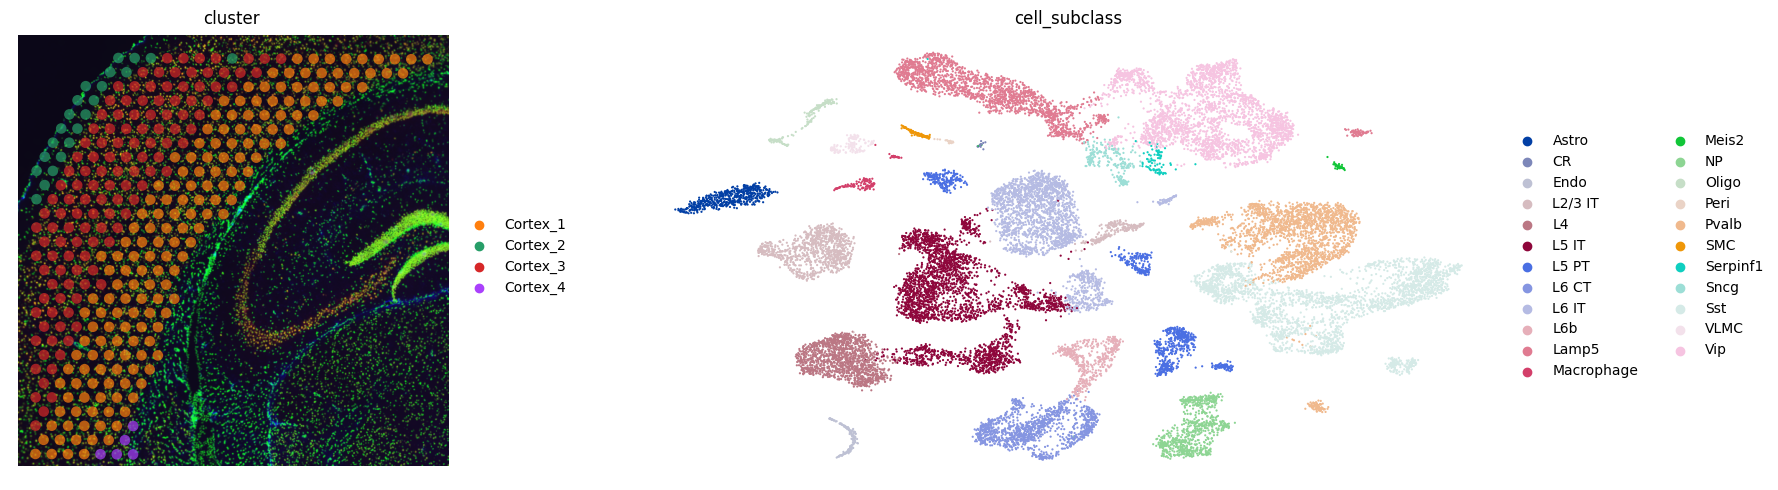

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
sc.pl.spatial(
    adata_st, color="cluster", alpha=0.7, frameon=False, show=False, ax=axs[0]
)
sc.pl.umap(
    adata_sc, color="cell_subclass", size=10, frameon=False, show=False, ax=axs[1]
)
plt.tight_layout()

****
### The _Tangram2-mapping_ idea: use scRNA-seq as a high-resolution template

The key idea is:

- **scRNA-seq** gives us rich, high-dimensional transcriptional profiles for individual cells, but no spatial coordinates.
- **Spatial transcriptomics** gives us approximate positions (spots or pixels), but usually with fewer genes and more technical dropouts.

_Tangram2-mapping_ aligns these two views by learning how to place each single-cell profile into spatial locations so that **predicted spatial gene expression** matches the observed spatial data as well as possible.

To do this, we choose a set of **training genes**:

- Genes that are informative across cell types (e.g. differentially expressed markers)  
- Genes that are measured with **reasonable quality** in both scRNA-seq and spatial data  

Typically we use on the order of **100–1000 marker genes**, stratified across cell types or subclasses. In practice, you can:

- use a ranked gene list (e.g. from `sc.tl.rank_genes_groups`) and take the top markers per group, or  
- specify your own curated marker list.

_Tangram2-mapping_ then optimizes a mapping so that, for these training genes, the **projected** spatial expression from scRNA-seq closely matches the **observed** spatial expression.

The overall procedure is:

1. Choose training genes.
2. Preprocess scRNA-seq and spatial `AnnData` objects so they share the same set of genes and ordering.
3. Run the mapping optimization.
4. Use the learned mapping to project annotations and full gene expression onto space.


### Pre-processing

For this case, we use 1401 marker genes as training genes.

In [5]:
sc.tl.rank_genes_groups(adata_sc, groupby="cell_subclass", use_raw=False)
markers_df = pd.DataFrame(adata_sc.uns["rank_genes_groups"]["names"]).iloc[0:100, :]
markers = list(np.unique(markers_df.melt().value.values))
len(markers)

1401

We prepares the data using `pp_adatas`, which does the following:
- Takes a list of genes from user via the `genes` argument. These genes are used as training genes.
- Annotates training genes under the `training_genes` field, in `uns` dictionary, of each AnnData. 
- Ensure consistent gene order in the datasets (_Tangram2-mapping_ requires that the the $j$-th column in each matrix correspond to the same gene).
- If the counts for a gene are all zeros in one of the datasets, the gene is removed from the training genes.
- If a gene is not present in both datasets, the gene is removed from the training genes.
- In the pp_adatas function, the gene names are converted to lower case to get rid of the inconsistent capitalization. If this is not wanted, you can set the parameter gene_to_lowercase = False 

In [6]:
tg2.mapping.pp_adatas(adata_sc, adata_st, genes=markers)

INFO:root:1280 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:14785 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.


Two datasets contain 1280 training genes of the 1401 originally provided, as some training genes have been removed.

### Find alignment

To find the optimal spatial alignment for scRNA-seq profiles, we use the `map_cells_to_space` function:
- The function maps iteratively as specified by `num_epochs`. We typically interrupt mapping  after the score plateaus. 
- The score measures the similarity between the gene expression of the mapped cells vs spatial data on the training genes.
- The default mapping mode is `mode='cells'`, which is recommended to run on a GPU. 
- Alternatively, one can specify `mode='clusters'` which averages the single cells beloning to the same cluster (pass annotations via  `cluster_label`). This is faster, and is our chioce when scRNAseq and spatial data come from different specimens.
- If you wish to run Tangram2-mapping with a GPU, set `device=cuda:0` otherwise use the set `device=cpu`. 
- `density_prior` specifies the cell density within each spatial voxel. Use `uniform` if the spatial voxels are at single cell resolution (_ie_ MERFISH). The default value, `rna_count_based`, assumes that cell density is proportional to the number of RNA molecules.

In [7]:
ad_map = tg2.mapping.map_cells_to_space(adata_sc, adata_st,
    mode="cells",
#     mode="clusters",
#     cluster_label='cell_subclass',  # .obs field w cell types
    density_prior='rna_count_based',
    num_epochs=1000,
    # device="cuda:0",
    device='cpu',
)

INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 1280 genes and rna_count_based density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.802, KL reg: 0.001, Entropy reg: -114689.906
Score: 0.813, KL reg: 0.000, Entropy reg: -27831.227
Score: 0.815, KL reg: 0.000, Entropy reg: -5720.513
Score: 0.815, KL reg: 0.000, Entropy reg: -3769.022
Score: 0.815, KL reg: 0.000, Entropy reg: -3065.810
Score: 0.815, KL reg: 0.000, Entropy reg: -2741.883
Score: 0.815, KL reg: 0.000, Entropy reg: -2554.312
Score: 0.815, KL reg: 0.000, Entropy reg: -2430.054
Score: 0.815, KL reg: 0.000, Entropy reg: -2342.734
Score: 0.815, KL reg: 0.000, Entropy reg: -2272.438


INFO:root:Saving results..


The mapping results are stored in the returned `AnnData` structure, saved as `ad_map`, structured as following:
- The cell-by-spot matrix `X` contains the probability of cell `i` to be in spot `j`.
- The `obs` dataframe contains the metadata of the single cells.
- The `var` dataframe contains the metadata of the spatial data.
- The `uns` dictionary contains a dataframe with various information about the training genes (saved as `train_genes_df`).

### Cell type maps

To visualize cell types in space, we invoke `project_cell_annotation` to transfer the `annotation` from the mapping to space. We can then call `plot_cell_annotation` to visualize it. You can set the `perc` argument to set the range to the colormap, which would help remove outliers.

INFO:root:spatial prediction dataframe is saved in `obsm` `tangram_ct_pred` of the spatial AnnData.


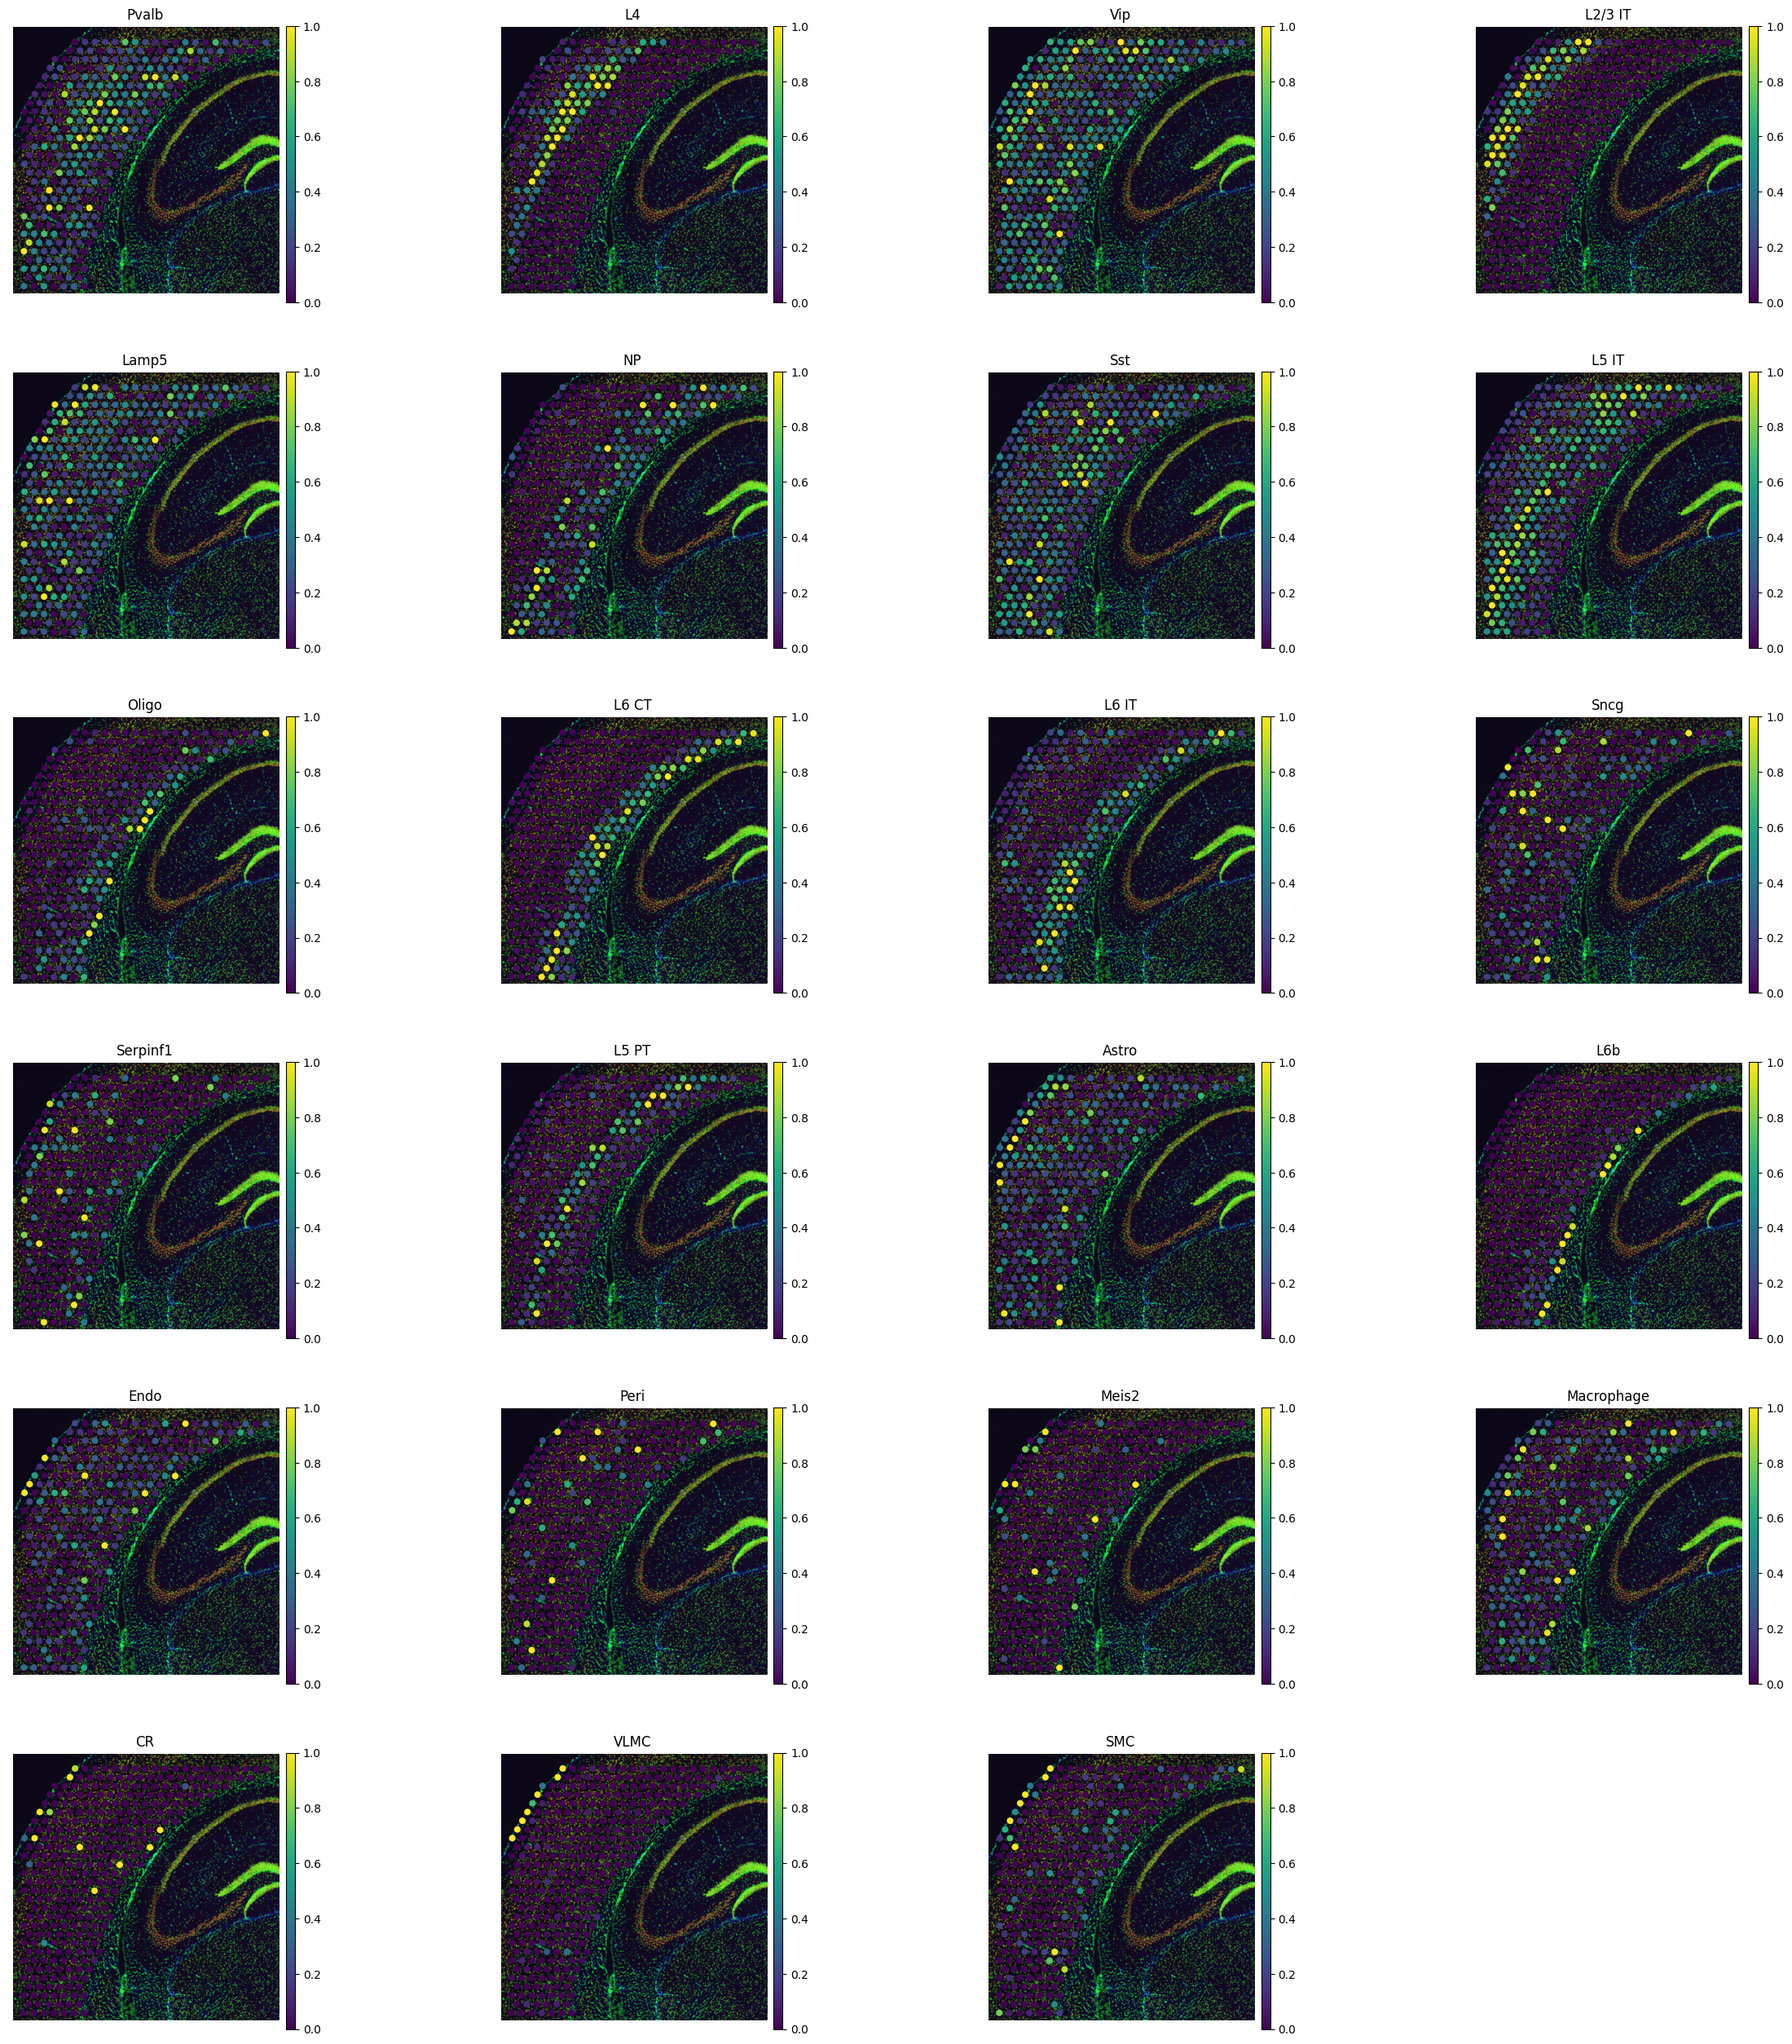

In [8]:
tg2.mapping.project_cell_annotations(ad_map, adata_st, annotation="cell_subclass")
annotation_list = list(pd.unique(adata_sc.obs['cell_subclass']))
tg2.mapping.plot_cell_annotation_sc(adata_st, annotation_list,perc=0.02)

The first way to get a sense if mapping was successful is to look for known cell type patterns. To get a deeper sense, we can use the helper `plot_training_scores` which gives us four panels:

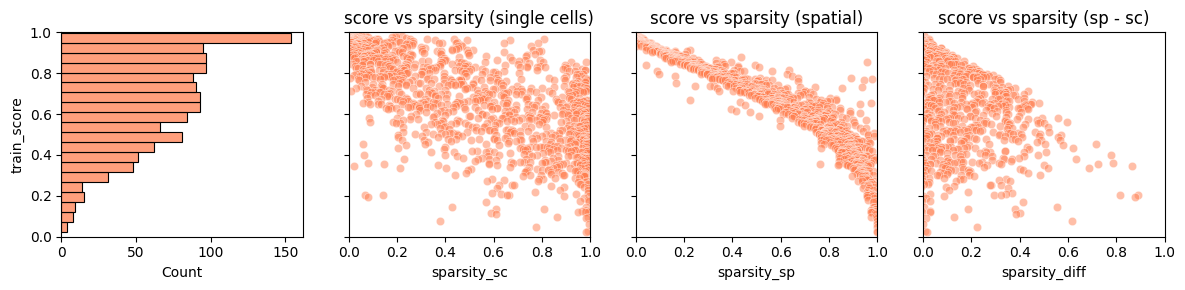

In [9]:
tg2.mapping.plot_training_scores(ad_map, bins=20, alpha=.5)

- The first panel is a histogram of the simlarity scores for each training gene.
- In the second panel, each dot is a training gene and we can observe the training score (y-axis) and the sparsity in the scRNA-seq data (x-axis) of each gene. 
- The third panel is similar to the second one, but contains the gene sparsity of the spatial data. Spatial data are usually more sparse than single cell data, a discrepancy which is often responsible for low quality mapping.
- In the last panel, we show the training scores as a function of the difference in sparsity between the dataset. For genes with comparable sparsity, the mapped gene expression is very similar to that in the spatial data. However, if a gene is quite sparse in one dataset (typically, the spatial data) but not in other, the mapping score is lower. This occurs as Tangram2-mapping cannot properly matched the gene pattern because of inconsistent amount of dropouts between the datasets.

Although the above plots give us a summary of scores at single-gene level, we would need to know _which_ are the genes are mapped with low scores. These information are stored in the dataframe `.uns['train_genes_df']`; this is the dataframe used to build the four plots above.

In [10]:
ad_map.uns['train_genes_df']

train_score  sparsity_sc  sparsity_sp  sparsity_diff
ppia              0.998262     0.000092     0.000000      -0.000092
ubb               0.997128     0.000092     0.000000      -0.000092
tmsb4x            0.996531     0.002811     0.000000      -0.002811
atp1b1            0.996112     0.014334     0.000000      -0.014334
ckb               0.995554     0.002765     0.000000      -0.002765
...                    ...          ...          ...            ...
kcnh6             0.074599     0.379131     0.996914       0.617783
lhx5              0.059371     0.996728     0.996914       0.000186
g630016g05rik     0.046982     0.774162     0.996914       0.222751
gm27199           0.029258     0.989722     0.996914       0.007191
cxcr4             0.023578     0.981610     0.996914       0.015303

[1280 rows x 4 columns]

### New spatial data via aligned single cells

If the mapping mode is `'cells'`, we can now generate the "new spatial data" using the mapped single cell: this is done via `project_genes`. The function accepts as input a mapping (`adata_map`) and corresponding single cell data (`adata_sc`). The result is a voxel-by-gene `AnnData`, formally similar to `adata_st`, but containing gene expression from the mapped single cell data rather than Visium. For downstream analysis, we always replace `adata_st` with the corresponding `ad_ge`.

In [11]:
ad_ge = tg2.mapping.project_genes(adata_map=ad_map, adata_sc=adata_sc)
ad_ge

AnnData object with n_obs × n_vars = 324 × 36826
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_MT', 'log1p_total_counts_MT', 'pct_counts_MT', 'n_counts', 'leiden', 'cluster', 'uniform_density', 'rna_count_based_density'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'sparsity', 'is_training'
    uns: 'cell_class_colors', 'cell_subclass_colors', 'hvg', 'neighbors', 'pca', 'umap', 'rank_genes_groups', 'training_genes', 'overlap_genes'

Let's choose a few training genes mapped with low score, to try to understand why.

In [12]:
genes = ['rragb', 'trim17', 'eno1b']
ad_map.uns['train_genes_df'].loc[genes]

train_score  sparsity_sc  sparsity_sp  sparsity_diff
rragb      0.360596     0.079919     0.867284       0.787365
trim17     0.204638     0.069641     0.959877       0.890236
eno1b      0.344015     0.022492     0.885802       0.863311

To visualize gene patterns, we use the helper `plot_genes`. This function accepts two voxel-by-gene `AnnData`: the actual spatial data  (`adata_measured`), and a Tangram2-mapping spatial prediction (`adata_predicted`). The function returns gene expression maps from the two spatial `AnnData` on the genes `genes`.


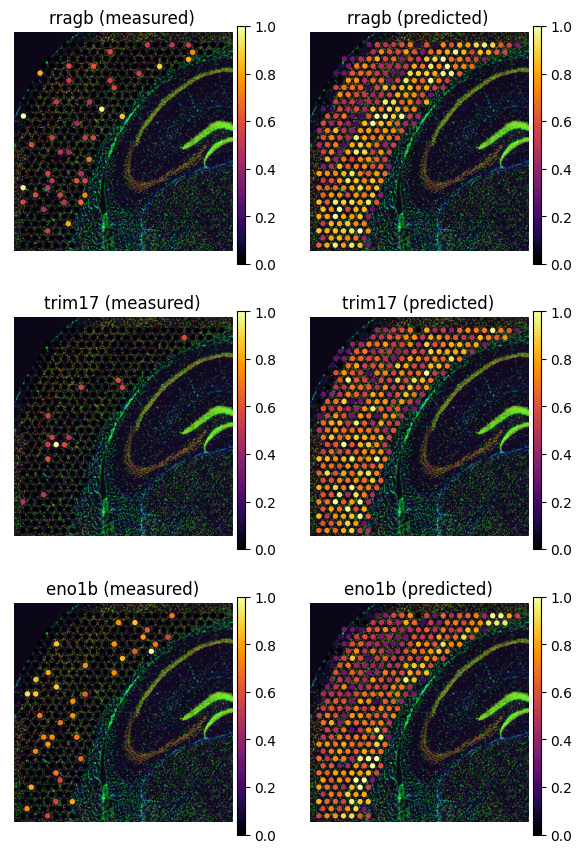

In [13]:
tg2.mapping.plot_genes_sc(genes, adata_measured=adata_st, adata_predicted=ad_ge, perc=0.02)

The above pictures explain the low training scores. Some genes are detected with very different levels of sparsity - typically they are much more sparse in the spatial data than in the scRNAseq. This is due to the fact that technologies like Visium are more prone to technical dropouts. Therefore, _Tangram2-mapping_ cannot find a good spatial alignment for these genes as the baseline signal is missing. However, so long as _most_ training genes are measured with high quality, we can trust mapping and use _Tangram2-mapping_ prediction to correct gene expression. This is an imputation method which relies on entirely different premises than those in probabilistic models. 

Another application is found by inspecting genes that are not detected in the spatial data, but are detected in the single cell data. They are removed before training with `pp_adatas` function, but _Tangram2-mapping_ can predict their expression.

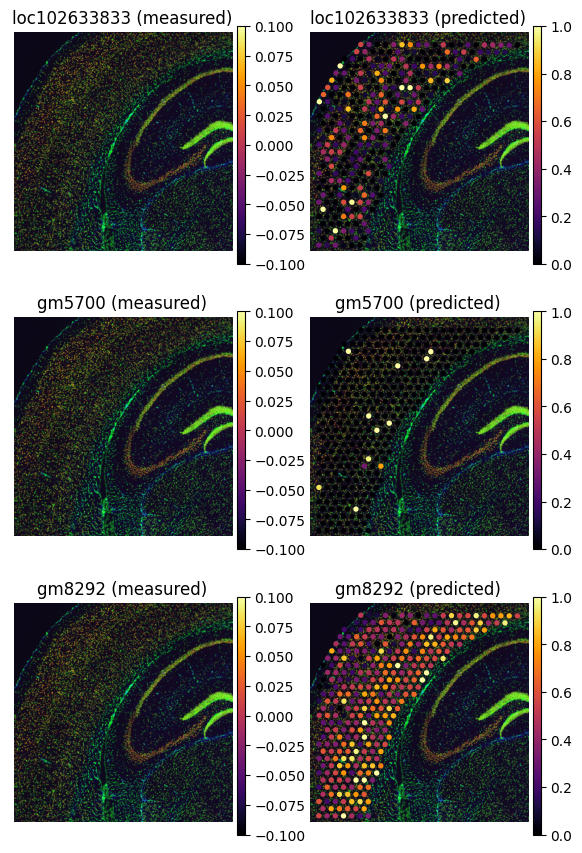

In [14]:
genes=['loc102633833', 'gm5700', 'gm8292']
tg2.mapping.plot_genes_sc(genes, adata_measured=adata_st, adata_predicted=ad_ge, perc=0.02)

- So far, we only inspected genes used to align the data (training genes), but the mapped single cell data, `ad_ge` contains the whole transcriptome. That includes more than 35k test genes.

In [15]:
(ad_ge.var.is_training == False).sum()

np.int64(35546)

We can use `plot_genes` to inspect gene expression of test genes as well. Inspecting the test transcriptome is an essential to validate mapping. At the same time, we need to be careful that some prediction might disagree with spatial data because of the technical droputs.

It is convenient to compute the similarity scores of all genes, which can be done by `compare_spatial_geneexp`. This function accepts two spatial AnnDatas (ie voxel-by-gene), and returns a dataframe with simlarity scores for all genes. Training genes are flagged by the boolean field `is_training`. If we also pass single cell AnnData to `compare_spatial_geneexp` function like below, a dataframe with additional sparsity columns - sparsity_sc (single cell data sparsity) and sparsity_diff (spatial data sparsity - single cell data sparsity) will return. This is required if we want to call `plot_test_scores` function later with the returned datafrme from `compare_spatial_geneexp` function.

In [16]:
df_all_genes = tg2.mapping.compare_spatial_geneexp(ad_ge, adata_st, adata_sc)
df_all_genes

score  is_training  sparsity_sp  sparsity_sc  sparsity_diff
ppia     0.999545         True     0.000000     0.000092      -0.000092
calm2    0.999378        False     0.000000     0.001751      -0.001751
calm1    0.999377        False     0.000000     0.000369      -0.000369
gapdh    0.999358        False     0.000000     0.000968      -0.000968
ubb      0.999254         True     0.000000     0.000092      -0.000092
...           ...          ...          ...          ...            ...
dct      0.001011        False     0.996914     0.997419      -0.000505
cxcl10   0.000968        False     0.996914     0.996866       0.000048
cyp3a13  0.000879        False     0.996914     0.998479      -0.001565
cckar    0.000832        False     0.996914     0.999309      -0.002395
foxd2    0.000668        False     0.996914     0.998064      -0.001151

[14785 rows x 5 columns]

The prediction on test genes can be graphically visualized using `plot_auc`:

<Figure size 640x480 with 0 Axes>

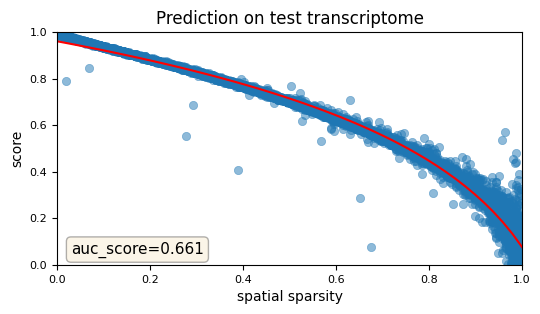

In [18]:
# sns.scatterplot(data=df_all_genes, x='score', y='sparsity_sp', hue='is_training', alpha=.5);  # for legacy
tg2.mapping.plot_auc(df_all_genes);


**This above figure is the most important validation plot in _Tangram2-mapping_.** Each dot represents a gene; the x-axis indicates the score, and the y-axis the sparsity of that gene in the spatial data.  Unsurprisingly, the genes predicted with low score represents very sparse genes in the spatial data, suggesting that the _Tangram2-mapping_ predictions correct expression in those genes. Note that curve observed above is typical of _Tangram2-mapping_ mappings: the area under that curve is the most reliable metric we use to evaluate mapping.

Let's inspect a few predictions. Some of these genes are biologically sparse, but well predicted.


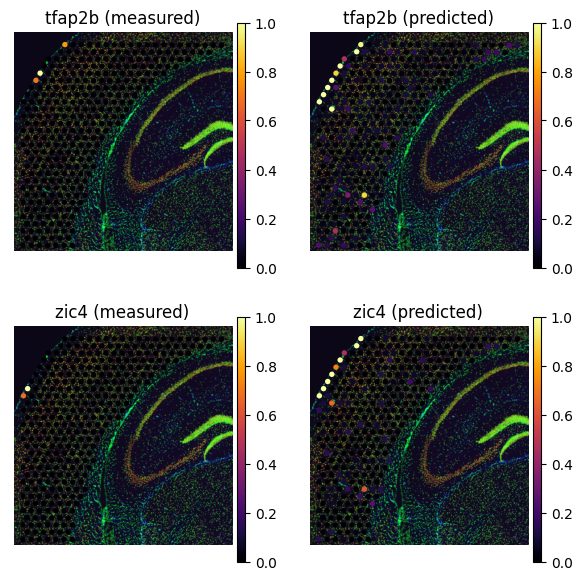

In [19]:
genes=['tfap2b', 'zic4']
tg2.mapping.plot_genes_sc(genes, adata_measured=adata_st, adata_predicted=ad_ge, perc=0.02)

Some non-sparse genes present petterns, that _Tangram_ accentuates:

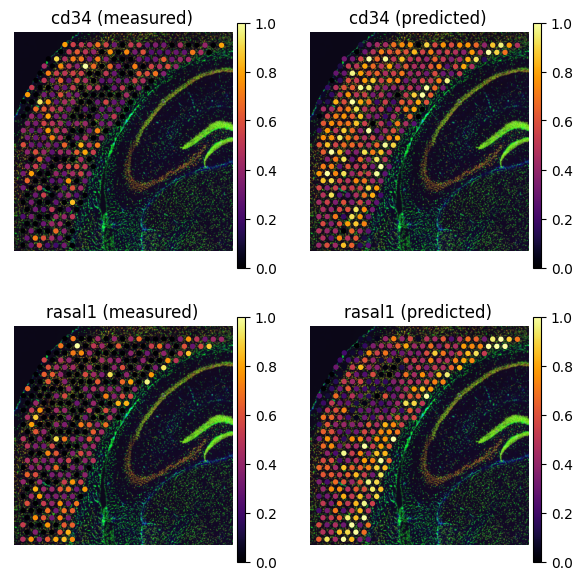

In [20]:
genes = ['cd34', 'rasal1']
tg2.mapping.plot_genes_sc(genes, adata_measured=adata_st, adata_predicted=ad_ge, perc=0.02)

Finally, some unannotated genes have unknown function. These genes are often hardly detected in spatial data but _Tangram2-mapping_ provides prediction:

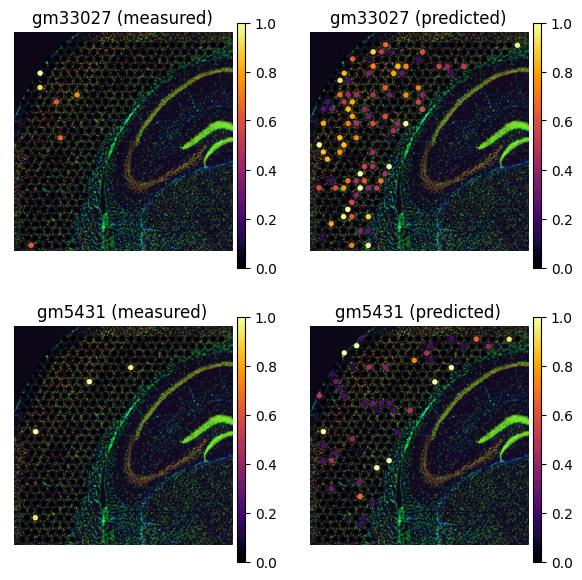

In [21]:
genes = ['gm33027', 'gm5431']
tg2.mapping.plot_genes_sc(genes[:5], adata_measured=adata_st, adata_predicted=ad_ge, perc=0.02)